# DWM flow simulation

The Dynamic-Wake-Meandering Wind-farm-flow model, `DWMFlowSimulation`, is a particle-based flow model that uses a set of sub models to simulate the particles, their meandering, deficit and wake-induced added turbulence as well as wake superposition.

![dwm_models.svg](dwm_models.svg)

Each turbine, has an associated row of `n_particles` particles. These particles holds information and a function, provided by the [`particleDeficitGenerator`](#ParticleDeficitGenerator), which is able to calculate the deficit profile at downstream positions. Furthermore, they have access to the `addedTurbulenceModel`, which is able to calculate the wake-induced added turbulence.

In each iteration, the time increments `dt` seconds and all particles, except the first, are moved (meandered) with the wind (mostly downstream,
but also in the crosswind and vertical direction). The movement is simulated by the `ParticleMotionModel`.

The first particle is fixed to the rotor center and updated with the wind speed and information from the [`WindTurbine`](https://dynamiks.pages.windenergy.dtu.dk/Dynamiks/notebooks/WindTurbines.html), e.g. rotor position and induction/ct.

When the second particles has moved `d_particle` diameters downstream, the first particle is released, and
the last particle is reset and fixed to the rotor center.

The wind speed at a given position is calculated in three steps:

1. Calculate the wake deficit from each wind turbine. To find the deficit from a wind turbine, its associated particles are searched to find the nearest up- and downstream particles. From the deficit profile of these two particles, the deficit value at the position is interpolated.
2. Having, the deficits from all upstream wind turbine, the sum of deficits is calculated by the `SuperpositionModel`, which defaults to linear sum.
3. Finally, the effective wind speed is calculated by subtracting the sum of deficits from the free-stream wind speed, which is provided by the [`Site`](https://dynamiks.pages.windenergy.dtu.dk/Dynamiks/notebooks/Site.html). 


![dwm_particles.svg](dwm_particles.svg)

The API interface for `DWMFlowSimulation` is shown below

In [1]:
from dynamiks.dwm import DWMFlowSimulation
help(DWMFlowSimulation.__init__)

Help on function __init__ in module dynamiks.dwm.dwm_flow_simulation:

__init__(self, site, windTurbines, particleDeficitGenerator, dt, particleMotionModel=<dynamiks.dwm.particle_motion_models.ParticleMotionModel object at 0x000002315E5F7C50>, d_particle=0.2, n_particles=None, wind_direction=270, step_handlers=None, superpositionModel=<py_wake.superposition_models.LinearSum object at 0x000002315E606150>, addedTurbulenceModel=<dynamiks.dwm.added_turbulence_models.SynchronizedAutoScalingIsotropicMannTurbulence object at 0x000002315E606490>, windTurbinesParticles=<class 'dynamiks.dwm.particles_model.WindTurbinesParticles'>)
    Parameters
    ----------
    site : Site
        site object, e.g. dynamiks.sites.TurbulenceFieldSite
        see https://dynamiks.pages.windenergy.dtu.dk/dynamiks/notebooks/Site.html
    windTurbines : WindTurbines
        windTurbines object e.g. dynamiks.wind_turbines.PyWakeWindTurbines, dynamiks.wind_turbines.HAWC2WindTurbines
        see https://dynamiks.page

## ParticleDeficitGenerator
Every time a particle is reset, the `WakeDeficitGenerator` models instantiates a `ParticleDeficitProfile` object with rotor size, rotor position, wind speed, induction and turbulence intensity and assigns it to the particle.

Current build-in options:
- jDWMAinslieGenerator
- PyWakeDeficitGenerator: 

In [2]:
# Setup site and wind turbines for examples below
import matplotlib.pyplot as plt
import numpy as np
from dynamiks.utils import doc_utils # use cached animations in sphinx documentation
from dynamiks.utils.test_utils import tfp, DemoSite, DemoWindTurbines
from dynamiks.dwm import DWMFlowSimulation
from dynamiks.views import Points, XView, XYView, YView
from py_wake.utils.plotting import setup_plot
from dynamiks.dwm.particle_deficit_profiles import jDWMAinslieGenerator, PyWakeDeficitGenerator
color_lst = ['#ff7f0e', '#2ca02c', '#d62728']

ws = 10 # mean wind speed
ti = 0.1 # turbulence intensity

# setup site
site = DemoSite(ws,ti)

# setup wind turbines
wts = DemoWindTurbines(x=[0], y=[0])
D = wts.diameter(0) # 80m
z_hub = wts.hub_height(0) # 70m

### jDWMAinslieGenerator

The jDWMAinslieGenerator uses the Ainslie eddy viscosity model implemented in [jdwm](https://gitlab.windenergy.dtu.dk/HAWC2Public/jdwm)

In [3]:
from dynamiks.dwm.particle_deficit_profiles.ainslie import jDWMAinslieGenerator
help(jDWMAinslieGenerator.__init__)

Help on function __init__ in module dynamiks.dwm.particle_deficit_profiles.ainslie:

__init__(self, boundaryConditionModel=<class 'jDWM.BoundaryCondition.madsen'>, viscosity_model=<class 'jDWM.EddyViscosityModel.madsen'>, solver=<jDWM.Solvers.implicit object at 0x0000023170DC5BD0>, scale_with_freestream=False, r_max=3, n_r=51)
    Parameters
    ----------
    boundaryConditionModel : jDWM.BoundaryConditionModel, optional
        boundary condition
    viscosity_model : jDWM.EddyViscosityModel, optional
        Eddy viscosity model
    solver : jDWM.Solver, optional
        solver
    scale_with_freestream : bool, optional
        Specify if normalized ainlie deficit should be scaled with freestream (i.e. without wakes) or
        effective wind speed including wakes (default)
    r_max : int or float
        Width of axisymmetric control volume [R] (normalized by rotor radius)
    n_r : int
        Number of points in axisymmetric control volume



See [jdwm](https://gitlab.windenergy.dtu.dk/HAWC2Public/jdwm) for a list of [boundary condition models](https://gitlab.windenergy.dtu.dk/HAWC2Public/jdwm/-/blob/master/jDWM/BoundaryCondition.py?ref_type=heads) and [eddy viscosity models](https://gitlab.windenergy.dtu.dk/HAWC2Public/jdwm/-/blob/master/jDWM/EddyViscosityModel.py?ref_type=heads) and [solvers](https://gitlab.windenergy.dtu.dk/HAWC2Public/jdwm/-/blob/master/jDWM/Solvers.py?ref_type=heads).

The solvers are described mathematically in https://wes.copernicus.org/articles/8/1387/2023/

Note, `r_max` must be large enough to allow the deficit to mix with the surrondings. If set too low, the deficit will stop dissipation and continue infinitely downstream

In [4]:
import jDWM.BoundaryCondition
import jDWM.EddyViscosityModel
import jDWM.Solvers

ainslie_wake = jDWMAinslieGenerator(boundaryConditionModel=jDWM.BoundaryCondition.madsen,
                                    viscosity_model=jDWM.EddyViscosityModel.madsen, 
                                    solver=jDWM.Solvers.implicit(),
                                    scale_with_freestream=False, # scale deficit with local wind speed including wakes
                                    r_max=3, # max width [R]
                                    n_r=51, # number of stations
                                    )

#### Example

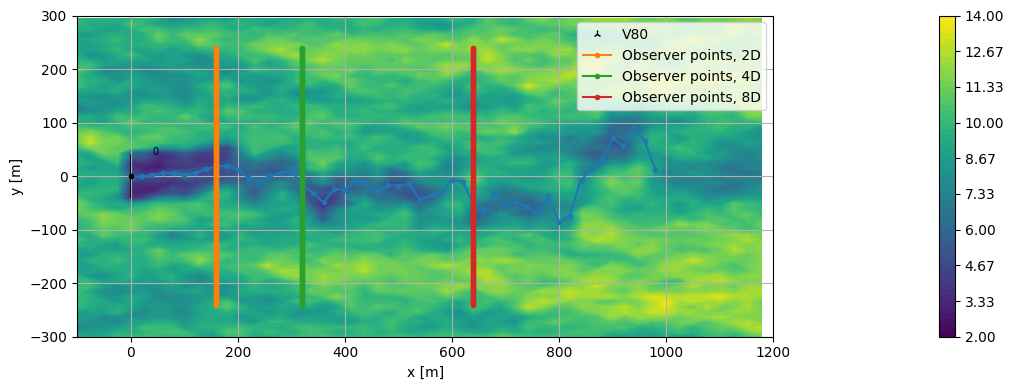

In [5]:
from dynamiks.utils.data_dumper import DataDumper
from dynamiks.visualizers import ParticleVisualizer
y_lst = np.linspace(-3*D, 3*D, 200) # observer points
d_lst = np.array([2,4,8])

# setup data dumper saving wind speed at observer points
xy_view = XYView(x=d_lst*D, z=z_hub, y=y_lst, adaptive=False)
ws_dumper = DataDumper(lambda fs : fs.get_windspeed(xy_view, include_wakes=True),
                       coords={'uvw':['u','v','w'], 'D':d_lst, 'y':y_lst})


fs = DWMFlowSimulation(site,DemoWindTurbines(), ainslie_wake, 1, addedTurbulenceModel=None, n_particles=50,
                       step_handlers=[ws_dumper])
                                     
fs.run(100) # run 100s to propagate wake at beyond 8D

#plot situation
ax = plt.figure(figsize=(12,4)).gca()
fs.show(view=XYView(z=70,x=np.linspace(-100,1200), y=np.linspace(-300,300), ax=ax, visualizers=[ParticleVisualizer()]))
for d, c in zip(d_lst, color_lst):
    plt.plot(y_lst*0+d*D,y_lst, '.-', color=c, label=f'Observer points, {d}D')
setup_plot(xlabel='x [m]', ylabel='y [m]')

In [6]:
fs.run(fs.time+1000, verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

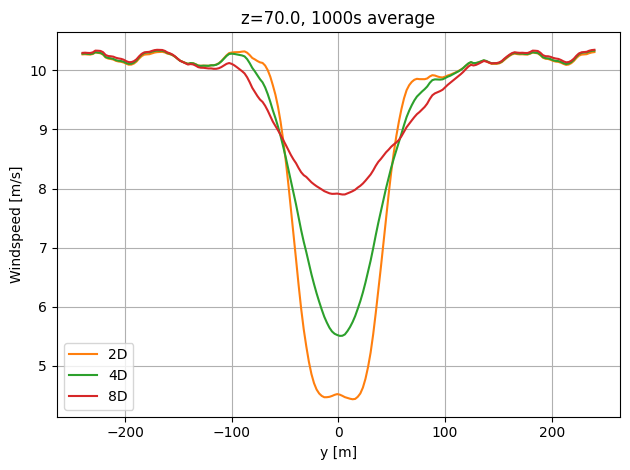

In [7]:
data_array = ws_dumper.to_xarray()[100:] # exclude first 100s
for d, c in zip(data_array.D.values, color_lst):
    data_array.sel(uvw='u', D=d).mean('time').plot(color=c, label=f'{d}D')
setup_plot(ylabel='Windspeed [m/s]', xlabel='y [m]', title=f'z={z_hub}, 1000s average')

### PyWakeDeficitGenerator

The `PyWakeDeficitGenerator` allows you to use any PyWake wake deficit models.

**Note**: Most PyWake models are static models calibrated to fit measurements or LES-CFD. This means that their empirical expansion includes the dynamic meandering, that Dynamiks puts on top of the static model. A recalibrated expansion model/factor is therefore needed.

In [8]:
from py_wake.deficit_models import NOJDeficit
noj_wake = PyWakeDeficitGenerator(deficitModel=NOJDeficit(rotorAvgModel=None))

#### Example

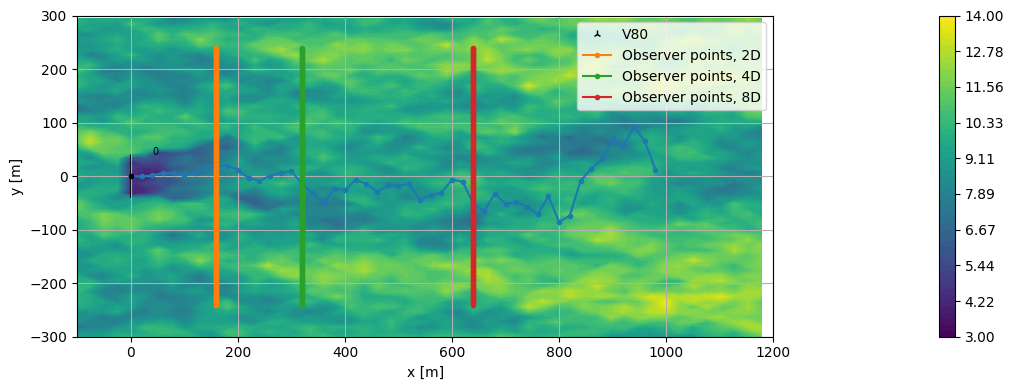

In [9]:
from dynamiks.utils.data_dumper import DataDumper
from dynamiks.visualizers import ParticleVisualizer
y_lst = np.linspace(-3*D, 3*D, 200) # observer points
d_lst = np.array([2,4,8])

# setup data dumper saving wind speed at observer points
xy_view = XYView(x=d_lst*D, z=z_hub, y=y_lst, adaptive=False)
ws_dumper = DataDumper(lambda fs : fs.get_windspeed(xy_view, include_wakes=True),
                       coords={'uvw':['u','v','w'], 'D':d_lst, 'y':y_lst})

fs = DWMFlowSimulation(site,DemoWindTurbines(), noj_wake, 1, addedTurbulenceModel=None, n_particles=50,
                       step_handlers=[ws_dumper])
                                     
fs.run(100) # run 99s to propagate wake at beyond 8D

#plot situation
ax = plt.figure(figsize=(12,4)).gca()
fs.show(view=XYView(z=70,x=np.linspace(-100,1200), y=np.linspace(-300,300), ax=ax, visualizers=[ParticleVisualizer()]))
for d, c in zip(d_lst, color_lst):
    plt.plot(y_lst*0+d*D,y_lst, '.-', color=c, label=f'Observer points, {d}D')
setup_plot(xlabel='x [m]', ylabel='y [m]')

In [10]:
fs.run(fs.time+1000, verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
# calculate the corresponding wind speed using PyWake (static)
from py_wake.deficit_models.noj import NOJDeficit
from py_wake.examples.data.hornsrev1 import V80
from py_wake.site._site import UniformSite
from py_wake.wind_farm_models.engineering_models import PropagateDownwind
from py_wake.flow_map import XYGrid
wfm = PropagateDownwind(UniformSite(), V80(), NOJDeficit())
pywake_data = wfm([0],[0],ws=10,wd=270).flow_map(XYGrid(x=d_lst*D, y=y_lst, h=z_hub))

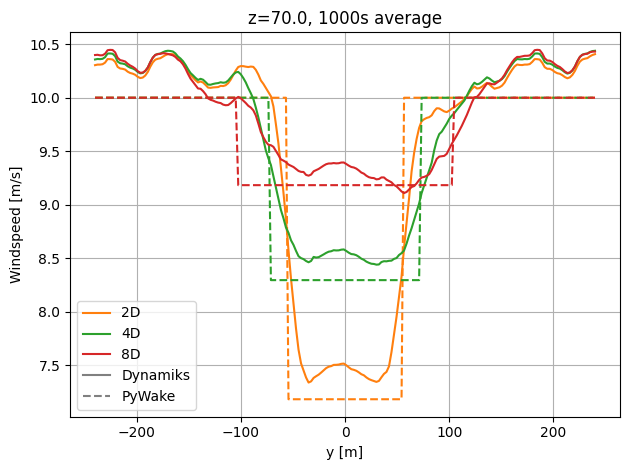

In [12]:
data_array = ws_dumper.to_xarray()

for d, c in zip(data_array.D.values, color_lst):
    data_array.sel(uvw='u', D=d).mean('time').plot(color=c, label=f'{d}D')
    pywake_data.WS_eff.sel(x=d*D).plot(color=c, ls='--')
plt.plot([],'-',color='gray', label='Dynamiks')
plt.plot([],'--',color='gray', label='PyWake')
setup_plot(ylabel='Windspeed [m/s]', xlabel='y [m]', title=f'z={z_hub}, 1000s average')

## Particle motion models

The particle motion model is responsible for the movement of the particles.
Currently, two models exists: [ParticleMotionModel](#ParticleMotionModel) (default) and [HillVortexParticleMotion](#HillVortexParticleMotion)

It is not evident, how to best model the particle motion and therefore, the models leave some options for the user on how the particles should be move in the x (downstream) as well as in the y/z (lateral/vertical) directions.

The downstream particle advection speed will affect how changes in the wake, e.g. caused by induction changes due to inflow changes and turbine control (derating, yaw, shut down/start up) will propagate downstream. It will, however, not affect the momentum conservation as the concentration of particles has no impact on the wake deficit.

The `ParticleMotionModel` optionally takes into account wakes from upstream wind turbines, but does not consider effects of its own induction. 

The `HillVortexParticleMotion` model extends the `ParticleMotionModel` with movement due to self induction, which means that the particles will deflect in case of yaw/tilt misalignment. 

### ParticleMotionModel
The API interface to the `ParticleMotionModel` is show below

In [13]:
from dynamiks.dwm.particle_motion_models import ParticleMotionModel
help(ParticleMotionModel.__init__)

Help on function __init__ in module dynamiks.dwm.particle_motion_models:

__init__(self, x_speed=<XSpeed.Global: 1>, temporal_filter=<dynamiks.dwm.particle_motion_models.CutOffFrq object at 0x0000023170D4D250>, spatial_filter=None, include_wakes=False)
    Models the motion (position and velocity) of the particles
    
    The velocity in the y and z direction are implicitly set to 'Particle'
    (i.e. the v and w speed at the current particle position)
    
    Note
    - The time ('current' or 'moment when the particle was released') may reflect
    a low pass filtered average (see the temporal_filter argument)
    - The position ('Rotor' or 'Particle') may represent a spatial average (see the spatial_filter argument)
    - The temporal and spatial filter models the same effect in different ways and probably only one of them should be used
    
    parameters
    ---------
    x_speed : SpeedType
        Particle advection speed along x axis (downstream)
        - Global: advection s

#### XSpeed
The `x_speed` argument determines the downstream speed of the particles. It can be set to either: 
- `XSpeed.Global`: All particles advect downstream with constant turbulence transport speed (`temporal_filter`, `spatial_fitler` and `include_wakes` are disregarded)
- `XSpeed.Rotor`: Each particle advects with constant speed, but the speed is determined as the wind speed at the rotor when the particle is released.
- `XSpeed.Particle`: Each particle advects with the local wind speed

When using `XSpeed.Rotor` and `XSpeed.Particle`, consider using a [Temporal filter](#Temporal-filters) and/or [Spatial filter](#Spatial-filters). In addition, the `include_wakes` argument should probably be set to `True`

##### Example showing the effect of XSpeed

In this example the downstream advection speed of two different particles are plotted for the three different XSpeed options

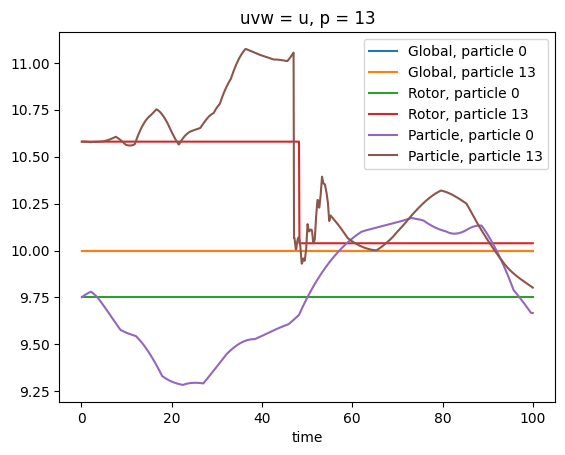

In [14]:
from dynamiks.utils.test_utils import DefaultDWMFlowSimulation
from dynamiks.dwm.particle_motion_models import ParticleMotionModel, XSpeed
from dynamiks.utils.data_dumper import DataDumper
import matplotlib.pyplot as plt
import numpy as np
for x_speed in [XSpeed.Global, XSpeed.Rotor, XSpeed.Particle]:
    data_dumper = DataDumper(lambda fs:fs.particle_velocity_uip[:,0], coords={'uvw':['u','v','w'], 'p':np.arange(20)})
    particleMotionModel=ParticleMotionModel(x_speed=x_speed, temporal_filter=None)
    fs = DefaultDWMFlowSimulation(ti=0.05, d_particle=1, n_particles=20, dt=0.1, particleMotionModel=particleMotionModel, step_handlers=[data_dumper])
    fs.run(100)
    da = data_dumper.to_xarray()
    for p in [0,13]:
        da.sel(uvw='u', p=p).plot(label=f'{x_speed.name}, particle {p}')
        
plt.legend();

The `Global` option results in both particles being moved with the turbulence transport speed, i.e. 10 m/s in this case.

The `Rotor` option results in particle 0 begin moved with 9.75 m/s. Particle 13 starts with a speed of 10.6 m/s, but after around 50s, it is reused as the new boundary particle, and therefore moved back to the rotor and its speed is reset to the current rotor speed.

The `Particle` option results in a time-varying speed. Also in this case, a significat step is seen when the particle is moved from far-downstream to the rotor to become the new boundary particle.

#### Temporal filters

The wake deficit (i.e. the particles in this context) is assumed to be advected downstream with the current, local wind speed. How "current" and how "local" that is, is, however, difficult to quantify.

The `ParticleMotionModel` applies an optional temporal  filter to the instant wind speed at the particle position. Note, that the [Spatial filter](#Spatial-filters) is similar, it may be possible to replaced the spatial filter by lowering temporal cut-off frequency.

Larsen (2008), argues that the temporal cut-off frequency should be $U/(2D)$, as shorter wave lengths will not be able to move a 1D wide wake same direction. Lio (2021) investigated the meandering using lidar data and found a cut-off frequency of $U/(4D)$ to be more appropriate.

References: 
- Larsen, G. C., Madsen, H. A., Thomsen, K., and Larsen, T. J. Wake meandering: a pragmatic approach, Wind Energy, 11, 377–395, https://doi.org/10.1002/we.267, 2008.
- Lio, W. H., Larsen, G. C., and Thorsen, G. R.: Dynamic wake tracking using a cost-effective LiDAR and Kalman filtering: Design, simulation and full-scale validation, Renew Energ., 172, 1073–1086, 2021.

##### Examples

In [15]:
from dynamiks.dwm.particle_motion_models import CutOffFrqLarsen2008, CutOffFrqLio2021, CutOffFrq
from scipy import signal
temporal_filter = .1 # cut-off frequency = 0.1 Hz
temporal_filter = CutOffFrqLarsen2008 # cut-off frequency = U/(2*D) Hz
temporal_filter = CutOffFrqLio2021 # cut-off frequency = U/(16*D) Hz
temporal_fitler = CutOffFrq(d) # cut-off frequency = U/(d*D) Hz

# N'th order Butterworth low pass filter with cut-off frequency(Wn) = 0.1 Hz
dt = 1 # time step
temporal_filter = signal.butter(N=1, Wn=.1, btype='low', fs=1 / dt, output='sos') 

#### Spatial filters

The easiest way to specify the spatial filter is via a PyWake `RotorAvgModel`, see https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/RotorAverageModels.html.

These models provides a number of normalized node positions and associated weights. The most relevant are problably the `CGIRotorAvg` model with either `7` or `21` nodes, see below.

The position of the nodes are scaled with the wake width, which is typically $2\sigma$ for gaussian profiles.

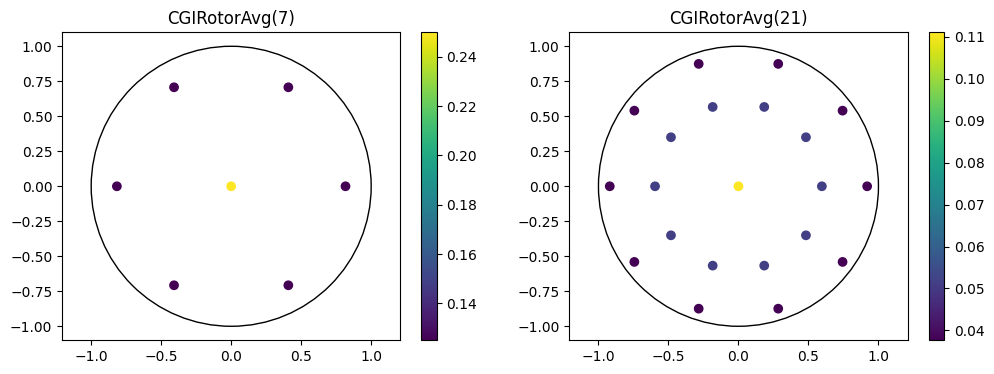

In [16]:
from py_wake.rotor_avg_models import CGIRotorAvg
axes = plt.subplots(1,2, figsize=(12,4))[1]
for ax, (name,sf) in zip(axes, [('CGIRotorAvg(7)', CGIRotorAvg(7)), 
                                ('CGIRotorAvg(21)',CGIRotorAvg(21))]):
    
    c = ax.scatter(sf.nodes_x, sf.nodes_y, c=sf.nodes_weight)
    ax.add_patch(plt.Circle((0,0),1,fill=False))
    plt.colorbar(c)
    ax.axis('equal')
    ax.set_title(name)

### HillVortexParticleMotion
The `HillVortexParticleMotion` model extends the default `ParticleMotionModel` with a model of the self induction of the emitting wind turbine. The self induction is modeled using Hill Vortex theory. The self-induction is perpendicular to the rotor, which means that yaw and tilt misalignment make the particles deflect

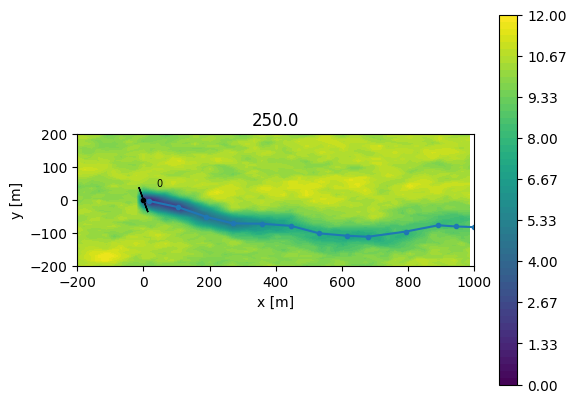

In [17]:
from dynamiks.dwm.particle_motion_models import HillVortexParticleMotion
from dynamiks.utils.test_utils import DefaultDWMFlowSimulation
from dynamiks.visualizers import ParticleVisualizer
import numpy as np
from dynamiks.views import XYView

fs = DefaultDWMFlowSimulation(ti=0.05, d_particle=1, n_particles=20, particleMotionModel=HillVortexParticleMotion())
fs.windTurbines.yaw = 20
fs.run(200)

fs.visualize(fs.time + 50, view=XYView(x=np.linspace(-200, 1000), y=np.linspace(-200, 200), z=70, visualizers=[ParticleVisualizer()]),
             id='HillVortexParticleMotion')

## Wind direction 
The `wind_direction` argument can be used simulate different wind directions. The default direction si 270 deg, where the `XYView` equals the `EastNorthView`. Internally in Dynamiks, the wind farm is rotated instead of the wind such that the turbulence transport direction is always along the x axis.

### Example

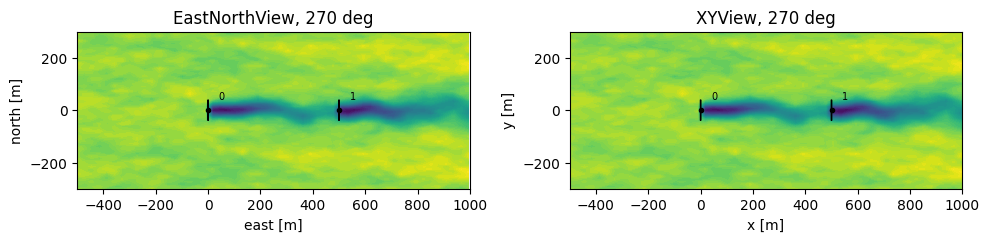

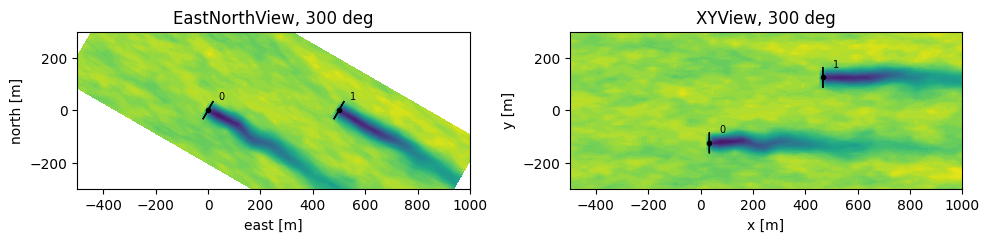

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from dynamiks.utils.test_utils import DefaultDWMFlowSimulation
from dynamiks.views import XYView, EastNorthView, MultiView
from dynamiks.visualizers.flow_visualizers import Flow2DVisualizer
from py_wake.utils.plotting import setup_plot

for wd in [270,300]:
    ax2,ax1 = plt.subplots(1,2, figsize=(10,4))[1]
    fs = DefaultDWMFlowSimulation(x=[0,500],y=[0,0], ti=0.05, d_particle=1, n_particles=20, wind_direction=wd)
    fs.run(100)
    fs.show(MultiView([
        XYView(x=np.linspace(-500,1000),y=np.linspace(-300,300),z=70, ax=ax1, flowVisualizer=Flow2DVisualizer(color_bar=False),
               title=f'XYView, {wd} deg', xlabel='x [m]', ylabel='y [m]'),
        EastNorthView(x=np.linspace(-500,1000),y=np.linspace(-300,300),z=70, ax=ax2, flowVisualizer=Flow2DVisualizer(color_bar=False),
                      title=f'EastNorthView, {wd} deg', xlabel='east [m]', ylabel='north [m]')]),
           block=False)